## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

In [3]:
metadata_path = '..\\Dataset\\fma_metadata'

In [4]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [5]:
genre_grps = genres.groupby('parent')


In [6]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [7]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [8]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [9]:
tracks = tracks.dropna()

In [10]:
tgen = list(tracks['genres'])
#print(tgen)

In [11]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [12]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [13]:
tracks['genres']=tgen

In [14]:
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [15]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [16]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [17]:
genre_dict[4][0]

144

In [18]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [19]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
genre_set = [4,5,10,12,15,17,21,38]
#genre_set = [10,5,12,15,17,21,38]
num_tracks = 320
tr_len = 300 # Training length per class
test_len = 20 # Testing length per class

The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [20]:
track_list = genre_dict[genre_set[0]]
for k in genre_set[1:]:
    t1 = genre_dict[k]
    i = 0
    while i<num_tracks:
        t2 = t1.pop()
        if t2 not in track_list:
            track_list.append(t2)
            i+=1
            
len(set(track_list))/len(genre_set)

320.0

Now we create the corresponding list of labels for this list.

In [21]:
label_list = [t for t in genre_set for i in range(num_tracks)]
len(label_list)/9

284.44444444444446

### Creating the training and testing data

Now we create the training and testing set partitions based on track index

In [22]:
tr_set = track_list[0:tr_len]
tr_lbl = label_list[0:tr_len]
test_set = track_list[tr_len:num_tracks]
test_lbl = label_list[tr_len:num_tracks]

print(len(tr_set),len(tr_lbl),len(test_set),len(test_lbl))

for k in range(1,len(genre_set)):
    tr_set+=track_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_set+=track_list[num_tracks*k+tr_len:num_tracks*(k+1)]
    tr_lbl+=label_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_lbl+=label_list[num_tracks*k+tr_len:num_tracks*(k+1)]

print(len(tr_set)/len(genre_set))
print(len(tr_lbl)/len(genre_set))
print(len(test_set)/len(genre_set))
print(len(test_lbl)/len(genre_set))

300 300 20 20
300.0
300.0
20.0
20.0


### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [23]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [24]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv',usecols=fields)

G:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,293,295,296,297,298,301,302,303,306,309,373,374,375,377,428,429,430,457,458) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [26]:
feat_tr = features.loc[features['feature'].isin(tr_set)]
feat_test = features.loc[features['feature'].isin(test_set)]

In [27]:
feat_tr['label'] = tr_lbl
feat_test['label'] = test_lbl

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shuffle the order of the data

In [28]:
feat_tr = feat_tr.sample(frac=1)
feat_test = feat_test.sample(frac=1)

Create separate numpy arrays and convert to type float

In [29]:
feat_tr = feat_tr.to_numpy()
tr_features = feat_tr[:,1:-1]
tr_features = tr_features.astype(float)
feat_test = feat_test.to_numpy()
test_features = feat_test[:,1:-1]
test_features = test_features.astype(float)

In [30]:
tr_features.shape

(2400, 19)

In [31]:
test_features.shape

(160, 19)

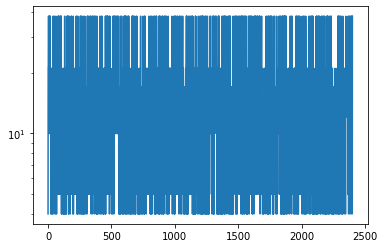

In [32]:
plt.semilogy(feat_tr[:,-1])

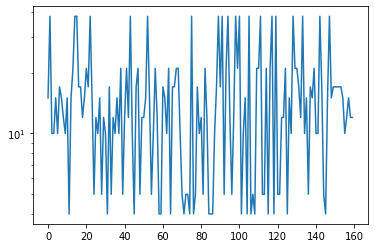

In [33]:
plt.semilogy(feat_test[:,-1])

### To obtain set of one hot codes for our labels

In [34]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

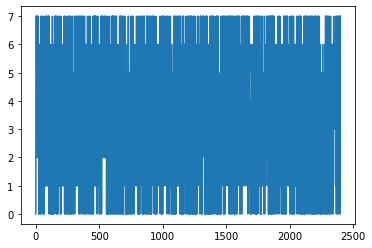

In [35]:
plt.plot(feat_tr[:,-1])

In [36]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(8, 2400)


In [37]:
feat_tr[0:10,-1]

array([0, 6, 6, 7, 7, 7, 6, 6, 3, 2], dtype=object)

In [38]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]]
(8, 2400)


## Training Stage

In [39]:
x_train = tr_features/1000
x_test = test_features/1000
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [40]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [41]:
label_dict

{'Jazz': 0,
 'Classical': 1,
 'Pop': 2,
 'Rock': 3,
 'Electronic': 4,
 'Folk': 5,
 'Hip-Hop': 6,
 'Experimental': 7}

In [42]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

In [43]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, objective='multi:hardprob', \
                                   n_estimators=700, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


Wall time: 19 s


In [44]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.70625


Test Set Accuracy =  0.29
Test Set F-score =  0.29
ROC AUC = 0.693
Confusion matrix, without normalization
[[ 4  1  3  3  3  3  2  1]
 [ 0 20  0  0  0  0  0  0]
 [ 1  0  9  6  1  1  1  1]
 [ 4  0  0  2  6  4  2  2]
 [ 5  0  1  4  5  2  1  2]
 [ 3  0  1  3  3  2  3  5]
 [ 0  0  0  1  6  5  2  6]
 [ 2  2  3  1  3  2  4  3]]


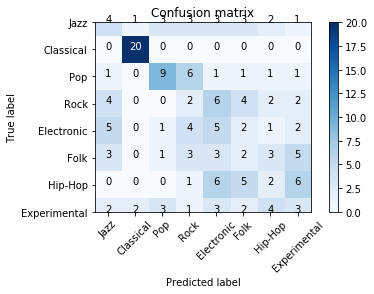

In [45]:
display_results(np.array(y_test,dtype=int), pred_probs)